In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import gzip
import pickle
import datetime

from collections import defaultdict
from scipy.spatial.distance import hamming
from sklearn.metrics import f1_score, precision_score, recall_score

In [2]:
dataset_list = ['yeast', 'woman'] #, 'diabete']
blackbox_list = ['rf', 'svm', 'mlp']

### Comparison between mixed and union approaches

In [3]:
mixed_fidelity_sn = defaultdict(list)
mixed_fidelity_rn = defaultdict(list)
union_fidelity_sn = defaultdict(list)
union_fidelity_rn = defaultdict(list)

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../output/20181031_1500_%s_%s_explanationsandmetrics.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']

            mixed_fidelity_sn[bb_name].append(r['fidelity_tree1_syn'])
            mixed_fidelity_rn[bb_name].append(r['fidelity_tree1_kNN'])

            union_fidelity_sn[bb_name].append(r['fidelity_tree2_syn'])
            union_fidelity_rn[bb_name].append(r['fidelity_tree2_kNN'])

        resfile.close()

2018-11-02 12:45:03.513027 dataset: yeast
2018-11-02 12:45:03.513134 blackbox: rf
2018-11-02 12:45:03.559821 blackbox: svm
2018-11-02 12:45:03.599886 blackbox: mlp
2018-11-02 12:45:03.639021 dataset: woman
2018-11-02 12:45:03.639099 blackbox: rf
2018-11-02 12:45:03.846425 blackbox: svm
2018-11-02 12:45:04.050817 blackbox: mlp


In [4]:
print('Table 2')
for bb_name in blackbox_list:
    print(bb_name)
    print('\tmixed fidelity sn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_sn[bb_name]), np.std(mixed_fidelity_sn[bb_name])))
    print('\tunion fidelity sn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_sn[bb_name]), np.std(union_fidelity_sn[bb_name])))
    print('---')
    print('\tmixed fidelity rn: %.3f \pm %.3f' % (
        np.mean(mixed_fidelity_rn[bb_name]), np.std(mixed_fidelity_rn[bb_name])))
    print('\tunion fidelity rn: %.3f \pm %.3f' % (
        np.mean(union_fidelity_rn[bb_name]), np.std(union_fidelity_rn[bb_name])))

Table 2
rf
	mixed fidelity sn: 1.000 \pm 0.000
	union fidelity sn: 0.876 \pm 0.047
---
	mixed fidelity rn: 0.833 \pm 0.089
	union fidelity rn: 0.831 \pm 0.111
svm
	mixed fidelity sn: 1.000 \pm 0.000
	union fidelity sn: 0.853 \pm 0.067
---
	mixed fidelity rn: 0.605 \pm 0.203
	union fidelity rn: 0.613 \pm 0.229
mlp
	mixed fidelity sn: 1.000 \pm 0.000
	union fidelity sn: 0.918 \pm 0.051
---
	mixed fidelity rn: 0.530 \pm 0.242
	union fidelity rn: 0.547 \pm 0.254


### Plot of fidelity changing alpha

In [5]:
print('Plot var alpha')
#TODO

Plot var alpha


In [6]:
mixed_fidelity_sn = defaultdict(lambda: defaultdict(list))
mixed_fidelity_rn = defaultdict(lambda: defaultdict(list))
mixed_hit = defaultdict(lambda: defaultdict(list))


resfile = gzip.open('../output/yeast_alphabeta.json.gz', 'rb')
for row in resfile:
    r = json.loads(row.decode('utf-8').strip())
    bb_name = r['bb_name']
    dataset_name = r['dataset_name']
    alpha = float(r['alpha'])
    mixed_fidelity_sn[bb_name][alpha].append(float(r['fidelity_tree1_syn']))
    mixed_fidelity_rn[bb_name][alpha].append(float(r['fidelity_tree1_kNN']))
    mixed_hit[bb_name][alpha].append(1.0 - float(r['hit_sm_tree1']))
resfile.close()

In [7]:
bb_name_map = {
    'rf': 'RF',
    'svm': 'SVM',
    'mlp': 'MLP'
}

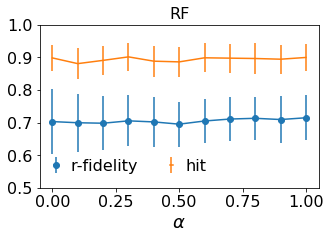

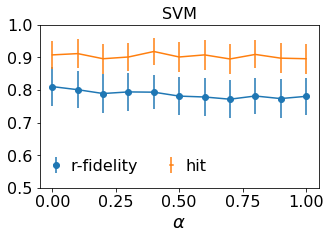

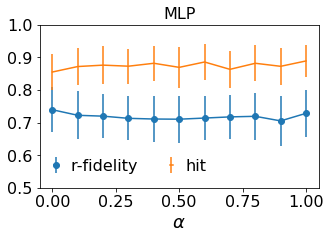

In [8]:
alphas = [np.round(x, 2) for x in np.arange(0.0, 1.1, 0.1)]

for bb_name in blackbox_list:
    fs_means = list()
    fs_std = list()
    fr_means = list()
    fr_std = list()
    hit_means = list()
    hit_std = list()
    for alpha in alphas:
        fs_means.append(np.mean(mixed_fidelity_sn[bb_name][alpha]))
        fs_std.append(np.std(mixed_fidelity_sn[bb_name][alpha]))
        fr_means.append(np.mean(mixed_fidelity_rn[bb_name][alpha]))
        fr_std.append(np.std(mixed_fidelity_rn[bb_name][alpha]))
        hit_means.append(np.mean(mixed_hit[bb_name][alpha]))
        hit_std.append(np.std(mixed_hit[bb_name][alpha]))
    
    plt.figure(figsize=(5,3))
    plt.errorbar(alphas, fr_means, yerr=np.array(fr_std)/2, marker='o', label='r-fidelity')
    plt.errorbar(alphas, hit_means, yerr=np.array(hit_std)/2, marker='', label='hit')
    plt.ylim([0.5, 1.0])
    plt.title(bb_name_map[bb_name] , fontsize=16)
    plt.xlabel(r'$\alpha$', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.legend(loc='lower left', fontsize=16, ncol=2, labelspacing=0, handlelength=0.2, frameon=False)
    plt.savefig('../fig/alpha_%s.png' % bb_name, format='png', bbox_inches='tight')
    plt.show()

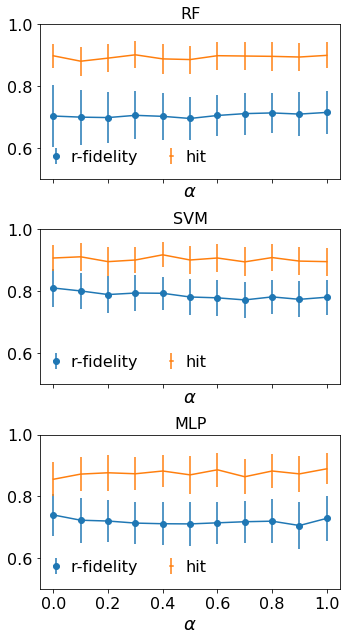

In [31]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5, 9))
alphas = [np.round(x, 2) for x in np.arange(0.0, 1.1, 0.1)]

#for ax, title, y in zip(axes.flat, titles, y_vals):
#    ax.plot(x, y)
#    ax.set_title(title)
#    ax.grid(True)

for ax, bb_name in zip(axes.flat,blackbox_list):
    fs_means = list()
    fs_std = list()
    fr_means = list()
    fr_std = list()
    hit_means = list()
    hit_std = list()
    for alpha in alphas:
        fs_means.append(np.mean(mixed_fidelity_sn[bb_name][alpha]))
        fs_std.append(np.std(mixed_fidelity_sn[bb_name][alpha]))
        fr_means.append(np.mean(mixed_fidelity_rn[bb_name][alpha]))
        fr_std.append(np.std(mixed_fidelity_rn[bb_name][alpha]))
        hit_means.append(np.mean(mixed_hit[bb_name][alpha]))
        hit_std.append(np.std(mixed_hit[bb_name][alpha]))
    
    #plt.figure(figsize=(5,3))
    ax.errorbar(alphas, fr_means, yerr=np.array(fr_std)/2, marker='o', label='r-fidelity')
    ax.errorbar(alphas, hit_means, yerr=np.array(hit_std)/2, marker='', label='hit')
    ax.set_ylim([0.5, 1.0])
    ax.set_title(bb_name_map[bb_name] , fontsize=16)
    ax.set_xlabel(r'$\alpha$', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.legend(loc='lower left', fontsize=16, ncol=2, labelspacing=0, handlelength=0.2, frameon=False)
    
    #plt.show()

fig.tight_layout()
fig.savefig('../fig/all_bb_alpha.png', format='png', bbox_inches='tight')

## Hit performances MARLENA vs GDT

In [9]:
#saving hit values for MARLENA (both mixed and union)
hit_mixed = defaultdict(lambda: defaultdict(list))
hit_union = defaultdict(lambda: defaultdict(list))

for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../output/20181031_1500_%s_%s_explanationsandmetrics.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']

            hit_mixed[dataset_name][bb_name].append(1.0 - r['hit_sm_tree1'])
            hit_union[dataset_name][bb_name].append(1.0 - r['hit_sm_tree2'])

        resfile.close()

2018-11-02 12:45:05.153266 dataset: yeast
2018-11-02 12:45:05.153429 blackbox: rf
2018-11-02 12:45:05.193853 blackbox: svm
2018-11-02 12:45:05.233287 blackbox: mlp
2018-11-02 12:45:05.273774 dataset: woman
2018-11-02 12:45:05.273843 blackbox: rf
2018-11-02 12:45:05.481829 blackbox: svm
2018-11-02 12:45:05.685786 blackbox: mlp


In [10]:
#saving hit values for GDT
hit_gdt = defaultdict(lambda: defaultdict(list))
for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../global_dt/%s_%s_labels.json.gz' % (bb_name, dataset), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_label = r['bb_label']
            gdt_label = r['gdt_label']

            hit_gdt[dataset][bb_name].append(1.0 - hamming(bb_label, gdt_label))
        resfile.close()

2018-11-02 12:45:05.899009 dataset: yeast
2018-11-02 12:45:05.899190 blackbox: rf
2018-11-02 12:45:05.917803 blackbox: svm
2018-11-02 12:45:05.937104 blackbox: mlp
2018-11-02 12:45:05.954112 dataset: woman
2018-11-02 12:45:05.954147 blackbox: rf
2018-11-02 12:45:06.043617 blackbox: svm
2018-11-02 12:45:06.144289 blackbox: mlp


Table 3 e plot-MIXED
yeast
	 rf
		hit MARLENA 0.964 pm 0.051
		hit GDT 0.947 pm 0.066
	 svm
		hit MARLENA 0.915 pm 0.081
		hit GDT 0.939 pm 0.068
	 mlp
		hit MARLENA 0.948 pm 0.064
		hit GDT 0.970 pm 0.052
woman
	 rf
		hit MARLENA 0.928 pm 0.068
		hit GDT 0.981 pm 0.041
	 svm
		hit MARLENA 0.846 pm 0.123
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.736 pm 0.164
		hit GDT 0.979 pm 0.048


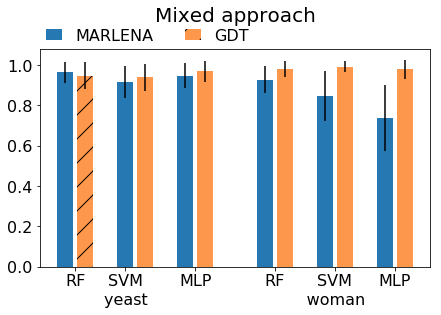

In [11]:
print('Table 3 e plot-MIXED')

plt.figure(figsize=(7,4))
index = 0
for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit_mixed[dataset_name][bb_name]), np.std(hit_mixed[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_mixed[dataset_name][bb_name]), 
                    yerr=np.std(hit_mixed[dataset_name][bb_name]), color='#2678b2', label='MARLENA')
        else:
            plt.bar(index, np.mean(hit_mixed[dataset_name][bb_name]), 
                    yerr=np.std(hit_mixed[dataset_name][bb_name]), color='#2678b2')
        index += 1
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label='GDT', hatch='/')
        else:
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b')
        index +=2
    index += 1
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5], ['RF', 'SVM', 'MLP']*2)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.title('Mixed approach',fontsize=20,y=1.10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                               woman', fontsize=16)
plt.savefig('../fig/MIXED_barplot.png', format='png', bbox_inches='tight')
plt.show()

Table 3 e plot-UNION
yeast
	 rf
		hit MARLENA 0.963 pm 0.051
		hit GDT 0.947 pm 0.066
	 svm
		hit MARLENA 0.920 pm 0.077
		hit GDT 0.939 pm 0.068
	 mlp
		hit MARLENA 0.954 pm 0.059
		hit GDT 0.970 pm 0.052
woman
	 rf
		hit MARLENA 0.927 pm 0.069
		hit GDT 0.981 pm 0.041
	 svm
		hit MARLENA 0.854 pm 0.121
		hit GDT 0.993 pm 0.025
	 mlp
		hit MARLENA 0.745 pm 0.155
		hit GDT 0.979 pm 0.048


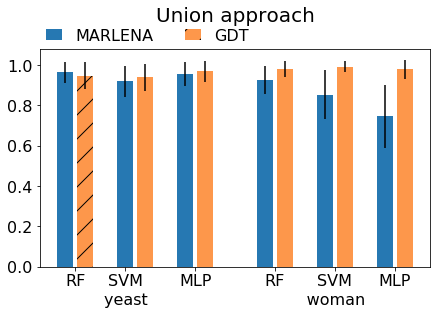

In [12]:
print('Table 3 e plot-UNION')

plt.figure(figsize=(7,4))
index = 0
for dataset_name in dataset_list:
    print(dataset_name)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        print('\t\thit MARLENA %.3f pm %.3f' % ( 
            np.mean(hit_union[dataset_name][bb_name]), np.std(hit_union[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_union[dataset_name][bb_name]), 
                    yerr=np.std(hit_union[dataset_name][bb_name]), color='#2678b2', label='MARLENA')
        else:
            plt.bar(index, np.mean(hit_union[dataset_name][bb_name]), 
                    yerr=np.std(hit_union[dataset_name][bb_name]), color='#2678b2')
        index += 1
        print('\t\thit GDT %.3f pm %.3f' % ( 
            np.mean(hit_gdt[dataset_name][bb_name]), np.std(hit_gdt[dataset_name][bb_name])))
        if dataset_name == 'yeast' and bb_name == 'rf':
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b', label='GDT', hatch='/')
        else:
            plt.bar(index, np.mean(hit_gdt[dataset_name][bb_name]), 
                    yerr=np.std(hit_gdt[dataset_name][bb_name]), color='#fd974b')
        index +=2
    index += 1
plt.xticks([0.5, 3.0, 6.5, 10.5, 13.5, 16.5], ['RF', 'SVM', 'MLP']*2)
plt.legend(loc=(0,1), fontsize=16, ncol=2, labelspacing=0, handlelength=1, frameon=False)
plt.title('Union approach',fontsize=20,y=1.10)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel('yeast                               woman', fontsize=16)
plt.savefig('../fig/UNION_barplot.png', format='png', bbox_inches='tight')
plt.show()

## Fidelities performances on interesting classes: MARLENA vs GDT

In [13]:
bb_labels = defaultdict(lambda: defaultdict(list))
mixed_marlena_labels = defaultdict(lambda: defaultdict(list))
union_marlena_labels = defaultdict(lambda: defaultdict(list))


for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../output/20181031_1500_%s_%s_explanationsandmetrics.json.gz' % (dataset, bb_name), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            bb_name = r['bb_name']
            dataset_name = r['dataset_name']
            bb_labels[dataset_name][bb_name].append(r['i2e_bb_label'])
            mixed_marlena_labels[dataset_name][bb_name].append(r['i2e_tree1_label']) 
            union_marlena_labels[dataset_name][bb_name].append(r['i2e_tree2_label']) 
            
        resfile.close()

2018-11-02 12:45:06.821162 dataset: yeast
2018-11-02 12:45:06.821254 blackbox: rf
2018-11-02 12:45:06.876239 blackbox: svm
2018-11-02 12:45:06.918388 blackbox: mlp
2018-11-02 12:45:06.956229 dataset: woman
2018-11-02 12:45:06.956284 blackbox: rf
2018-11-02 12:45:07.174862 blackbox: svm
2018-11-02 12:45:07.446627 blackbox: mlp


In [14]:
gdt_labels = defaultdict(lambda: defaultdict(list))
for idx, dataset in enumerate(dataset_list):
    print(datetime.datetime.now(), 'dataset: %s' % dataset)
    for bb_name in blackbox_list: 
        print(datetime.datetime.now(), 'blackbox: %s' % bb_name)
        
        resfile = gzip.open('../global_dt/%s_%s_labels.json.gz' % (bb_name, dataset), 'rb')
        for row in resfile:
            r = json.loads(row.decode('utf-8').strip())
            gdt_label = r['gdt_label']

            gdt_labels[dataset][bb_name].append(r['gdt_label'])
        resfile.close() 

2018-11-02 12:45:07.661541 dataset: yeast
2018-11-02 12:45:07.661603 blackbox: rf
2018-11-02 12:45:07.667273 blackbox: svm
2018-11-02 12:45:07.673404 blackbox: mlp
2018-11-02 12:45:07.678188 dataset: woman
2018-11-02 12:45:07.678250 blackbox: rf
2018-11-02 12:45:07.704573 blackbox: svm
2018-11-02 12:45:07.735327 blackbox: mlp


In [15]:
print('Table 4 - MIXED')

for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        bl = np.asarray(bb_labels[dataset][bb_name])
        ml = np.asarray(mixed_marlena_labels[dataset][bb_name])
        nbr_instances = len(bl)
        gl = np.asarray(gdt_labels[dataset][bb_name][:nbr_instances])

        f1score_marlena = f1_score(bl, ml, average=None)
        f1score_gdt = f1_score(bl, gl, average=None)

        marlena_values = list()
        gdt_values = list()
        for i in range(0, len(bl[0])):
            #qui faccio solo la media e la deviazione standard per le features che sono interessanti,
            #ovvero quelle che non sono tutte 0 o tutte 1 
            flag = 0 < np.sum(bl[:,i])/len(bl) < 1
            if flag:
                marlena_values.append(f1score_marlena[i])
                gdt_values.append(f1score_gdt[i])

        print('MARLENA: avg %.3f, std %.3f, median %.3f' % (
            np.mean(marlena_values), np.std(marlena_values), np.median(marlena_values)))
        print('GDT:\t avg %.3f, std %.3f, median %.3f' % (
            np.mean(gdt_values), np.std(gdt_values), np.median(gdt_values)))
    print('')

Table 4 - MIXED
yeast
	 rf
MARLENA: avg 0.514, std 0.382, median 0.666
GDT:	 avg 0.439, std 0.324, median 0.522
	 svm
MARLENA: avg 0.540, std 0.345, median 0.697
GDT:	 avg 0.613, std 0.323, median 0.738
	 mlp
MARLENA: avg 0.821, std 0.111, median 0.808
GDT:	 avg 0.786, std 0.119, median 0.805

woman
	 rf
MARLENA: avg 0.383, std 0.369, median 0.401
GDT:	 avg 0.615, std 0.265, median 0.663
	 svm
MARLENA: avg 0.250, std 0.275, median 0.132
GDT:	 avg 0.582, std 0.367, median 0.782
	 mlp
MARLENA: avg 0.249, std 0.287, median 0.059
GDT:	 avg 0.553, std 0.369, median 0.661



/home/user/venvs/LORE_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/user/venvs/LORE_env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
print('Table 4 - UNION')

for idx, dataset in enumerate(dataset_list):
    print(dataset)
    for bb_name in blackbox_list:
        print('\t', bb_name)
        bl = np.asarray(bb_labels[dataset][bb_name])
        ml = np.asarray(union_marlena_labels[dataset][bb_name])
        nbr_instances = len(bl)
        gl = np.asarray(gdt_labels[dataset][bb_name][:nbr_instances])

        f1score_marlena = f1_score(bl, ml, average=None)
        f1score_gdt = f1_score(bl, gl, average=None)

        marlena_values = list()
        gdt_values = list()
        for i in range(0, len(bl[0])):
            flag = 0 < np.sum(bl[:,i])/len(bl) < 1
            if flag:
                marlena_values.append(f1score_marlena[i])
                gdt_values.append(f1score_gdt[i])

        print('MARLENA: avg %.3f, std %.3f, median %.3f' % (
            np.mean(marlena_values), np.std(marlena_values), np.median(marlena_values)))
        print('GDT:\t avg %.3f, std %.3f, median %.3f' % (
            np.mean(gdt_values), np.std(gdt_values), np.median(gdt_values)))
    print('')

Table 4 - UNION
yeast
	 rf
MARLENA: avg 0.514, std 0.383, median 0.670
GDT:	 avg 0.439, std 0.324, median 0.522
	 svm
MARLENA: avg 0.574, std 0.327, median 0.710
GDT:	 avg 0.613, std 0.323, median 0.738
	 mlp
MARLENA: avg 0.846, std 0.092, median 0.823
GDT:	 avg 0.786, std 0.119, median 0.805

woman
	 rf
MARLENA: avg 0.361, std 0.366, median 0.319
GDT:	 avg 0.615, std 0.265, median 0.663
	 svm
MARLENA: avg 0.225, std 0.282, median 0.104
GDT:	 avg 0.582, std 0.367, median 0.782
	 mlp
MARLENA: avg 0.251, std 0.298, median 0.042
GDT:	 avg 0.553, std 0.369, median 0.661

